# Complimentary guide to computing transports in ECCO with ECCOv4-py

Re-writing a [tutorial](http://users.oden.utexas.edu/~tsmith/osm20_eccov4py_townhall_tsmith.html) written by Tim Smith for OSM20

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client
import ecco_v4_py as ecco

import warnings

In [2]:
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

Read in NetCDF files downloaded from the [ECCO Drive](https://ecco.jpl.nasa.gov/drive/login?dest=L2RyaXZlL2ZpbGVz)

## Binary Files
If you have binary files (like aste, North Atlantic strip, regional domains...), **ECCOv4-py** uses a wrapped function around the `open_mdsdataset` function from the `xmitgcm` package. Refer to original tutorial for more info.

In [3]:
# Specific to my local machine (Macbook)
download_dir = f'{os.getenv("WORK")}/eccov4r4'

In [4]:
print(os.getenv("WORK"))

/Users/ivanaescobar/work


In [5]:
%%time
ds = xr.open_mfdataset(glob(f'{download_dir}/nctiles_monthly/*/*/*.nc'))

CPU times: user 1min 2s, sys: 3.18 s, total: 1min 5s
Wall time: 1min 3s


In [6]:
ds.data_vars

Data variables:
    ADVx_TH   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFxE_TH   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFyE_TH   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELMASS  (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    VVELMASS  (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>

In [7]:
ds.UVELMASS.data

,Array,Chunk
Bytes,6.57 GB,21.06 MB
Shape,"(312, 50, 13, 90, 90)","(1, 50, 13, 90, 90)"
Count,1248 Tasks,312 Chunks
Type,float32,numpy.ndarray


In [8]:
ds.ADVx_TH.data

,Array,Chunk
Bytes,6.57 GB,21.06 MB
Shape,"(312, 50, 13, 90, 90)","(1, 50, 13, 90, 90)"
Count,1248 Tasks,312 Chunks
Type,float32,numpy.ndarray


In [9]:
ds.DFxE_TH

<xarray.DataArray 'DFxE_TH' (time: 312, k: 50, tile: 13, j: 90, i_g: 90)>
dask.array<getitem, shape=(312, 50, 13, 90, 90), dtype=float32, chunksize=(1, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
    Z         (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile      (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    timestep  (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    units:      degC.m^3/s
    long_name:  Zonal      Diffusive Flux of Pot.Temperature

In [10]:
%%time
dsg = xr.open_dataset(f'{download_dir}/nctiles_grid/ECCO-GRID.nc')
print(f'Grid coordinate dataset is {dsg.nbytes/1e9:.02f} GB')

Grid coordinate dataset is 0.09 GB
CPU times: user 21.6 ms, sys: 1.82 ms, total: 23.5 ms
Wall time: 23.7 ms


Explicitly loading small data sets such as `dsg`.

In [11]:
dsg.load()
ds = ds.merge(dsg)

In [12]:
client = Client(n_workers=16) # cores available
client

Client Scheduler: tcp://127.0.0.1:49926 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 17.18 GB


__BEWARE__: This process overworked my laptop, I was using 56 cores in the `Client`! My laptop has 16 cores. 
You can find this out by using:
``` 
sysctl hw.ncpu
```
or by reading __About this Mac__

# Walkthrough of plotted results

### UVELMASS of 13 tiles
On sea surface, `k=0`, time mean over all available data, 1992-2017.

__BEWARE__: plotting command produced the following warning.
`distributed.worker - WARNING - Memory use is high but worker has no data to store to disk. Perhaps some other process is leaking memory?`
Was this because of __Dropbox__ running in the background?

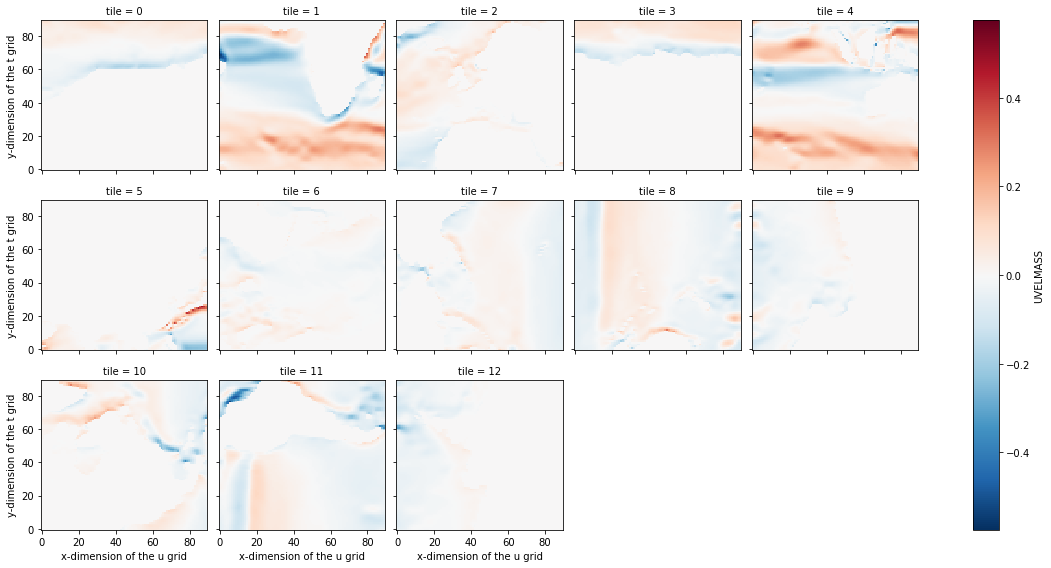

In [13]:
ds.UVELMASS.isel(k=0).mean('time').plot(col='tile',col_wrap=5,figsize=(16,8));

### Time mean surface currents

A common problem with plotting MITgcm results comes from funky velocity fields, `UVELMASS` and `VVELMASS`, on each tile. Here is the 'unrotated' field plotted on the global ocean

In [14]:
plt.rcParams.update({'figure.figsize':(12,6),'font.size':20,'axes.linewidth':1.5,'lines.linewidth':3})

Text(0.5, 1.0, 'Unrotated time mean surface currents')

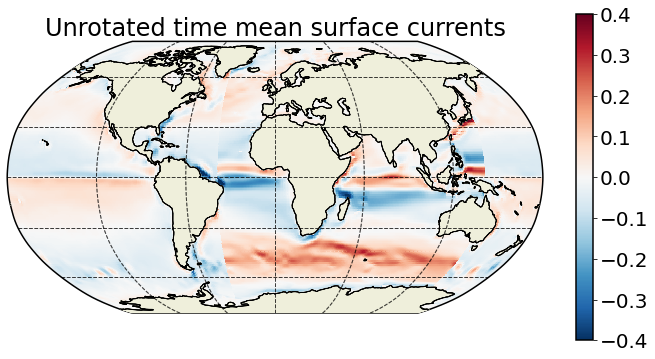

In [15]:
ecco.plot_proj_to_latlon_grid(ds.XG,ds.YC,ds.UVELMASS.isel(k=0).mean('time'),show_colorbar=True,cmin=-.4,cmax=.4)
plt.title('Unrotated time mean surface currents')

`ECCOv4-py` will fix that with their `UEVNfromUXVY` method

In [16]:
%%time
uvel,vvel = ecco.vector_calc.UEVNfromUXVY(ds.UVELMASS,ds.VVELMASS,ds)

CPU times: user 1.36 s, sys: 32.7 ms, total: 1.39 s
Wall time: 1.39 s


In [ ]:
ecco.plot_proj_to_latlon_grid(ds.XG,ds.YC,uvel.isel(k=0).mean('time'),show_colorbar=True,cmin=-.4,cmax=.4)
plt.title('Time mean surface currents')

This plot is crashing my local computer. Try on more cores with more memory

### Atlantic meridional heat transport across 26$^\circ$N

Because we’re computing transport, we want the files containing `UVELMASS` and `VVELMASS` for volumetric transport, and `ADVx_TH`, `ADVy_TH` and `DFxE_TH`, `DFyE_TH` for the advective and diffusive components of heat transport, respectively.

In [17]:
print(ecco.get_available_basin_names())

['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents']


In [18]:
%%time
mht = ecco.calc_meridional_heat_trsp(ds,lat_vals=26,basin_name='atlExt')

loading  basins.data
data shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
data_tiles shape  (13, 90, 90)
data_tiles shape =  (13, 90, 90)
loading  basins.data
data shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
data_tiles shape  (13, 90, 90)
data_tiles shape =  (13, 90, 90)
CPU times: user 19 s, sys: 2.62 s, total: 21.6 s
Wall time: 39.4 s


In [19]:
%%time 
mht.load();

CPU times: user 45 µs, sys: 4 µs, total: 49 µs
Wall time: 54.1 µs


<xarray.Dataset>
Dimensions:      (k: 50, lat: 1, time: 312)
Coordinates:
  * time         (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
  * k            (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * lat          (lat) int64 26
    PHrefC       (k) float32 49.05 147.15 245.25 ... 53574.863 57940.312
    drF          (k) float32 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    Z            (k) float32 -5.0 -15.0 -25.0 ... -5039.25 -5461.25 -5906.25
Data variables:
    heat_trsp_z  (time, k, lat) float64 0.5193 0.03655 ... 0.002312 -0.0004046
    heat_trsp    (time, lat) float64 0.6414 0.8293 1.076 ... 0.8356 0.9267

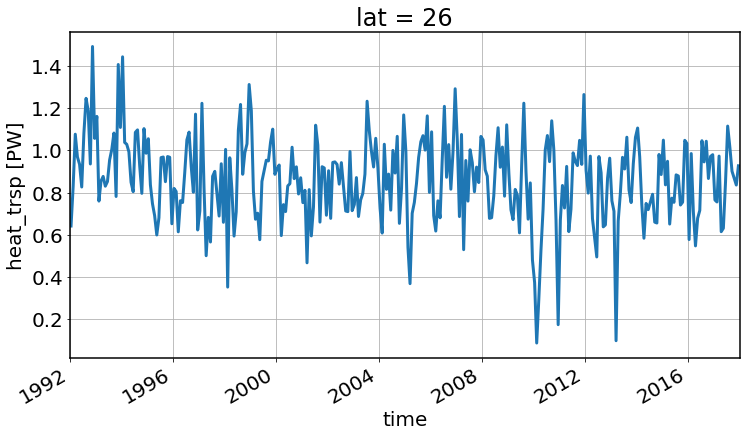

In [20]:
mht.heat_trsp.plot(xlim=('1992','2018'))
plt.grid();

In [21]:
def quick_depth_plot(xda): 
    fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True,sharex=True)
    
    # Time evolving
    plt.subplot(1,4,(1,3))
    xda.plot(y='Z',x='time',robust=True)
    plt.xlabel('')
    
    # time mean
    plt.subplot(1,4,4)
    xda.mean('time').plot(y='Z')
    plt.ylabel('')
    plt.grid()
    
    plt.tight_layout()
    
def depth_slice_plot(xda,z_mid=-500):

    for xda_slice in [xda.where(xda.Z>z_mid,drop=True),xda.where(xda.Z<z_mid,drop=True)]:
        quick_depth_plot(xda_slice)

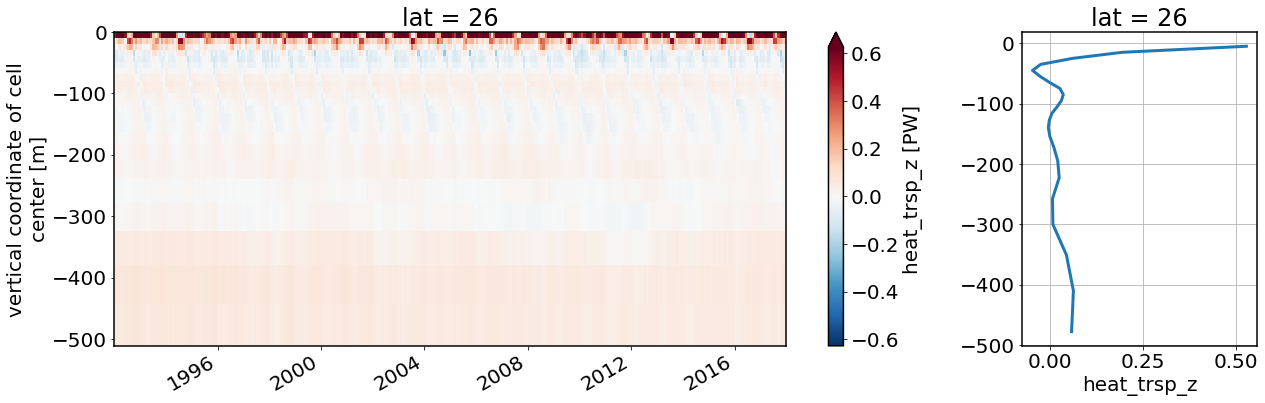

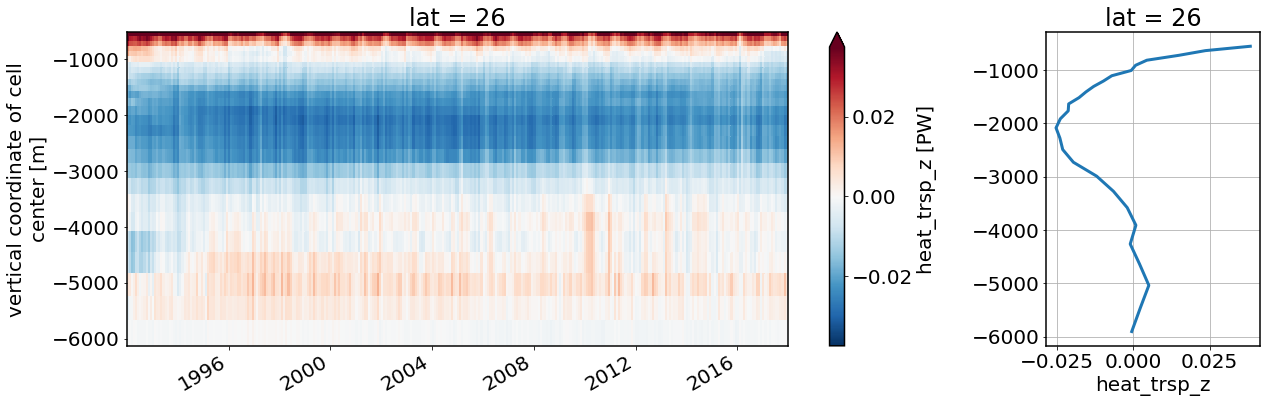

In [22]:
depth_slice_plot(mht.heat_trsp_z)

### Drake passage volume transport

using a pre-defined section of the ocean. 

In [23]:
%%time
# easy as: ecco.calc_section_vol_trsp(ds,'Drake Passage')
# or:
dp = ecco.calc_section_vol_trsp(ds,pt1=[-68,-54],pt2=[-63,-66])

CPU times: user 2.91 s, sys: 131 ms, total: 3.04 s
Wall time: 207 ms


In [24]:
%%time
dp.load();

CPU times: user 20.6 s, sys: 1.52 s, total: 22.2 s
Wall time: 31.7 s


<xarray.Dataset>
Dimensions:     (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, tile: 13, time: 312)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    PHrefC      (k) float32 49.05 147.15 245.25 ... 53574.863 57940.312
    drF         (k) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    Z           (k) float32 -5.0 -15.0 -25.0 ... -5039.25 -5461.25 -5906.25
    timestep    (time) int64 732 1428 2172 2892 ... 225708 226452 227172 227904
  * tile        (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g         (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    vol_trsp_z  (time, k) float64 1.83 1.553 1.239 1.107 ... 0.0 0.0 0.0 0.0
    vol_trsp    (time) float64 150.0 145.8 150.9 150.6 ... 147.3 148.3 148.3
    maskW       (tile, j, i_g) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    maskS       (tile, j_g, i) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

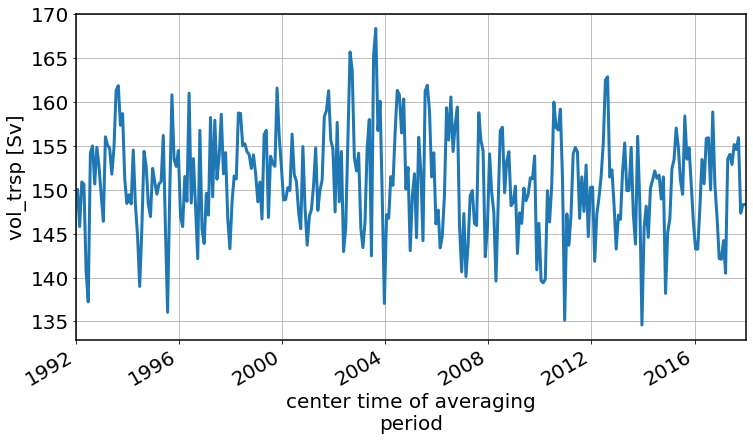

In [25]:
dp.vol_trsp.plot(xlim=['1992','2018'])
plt.grid();

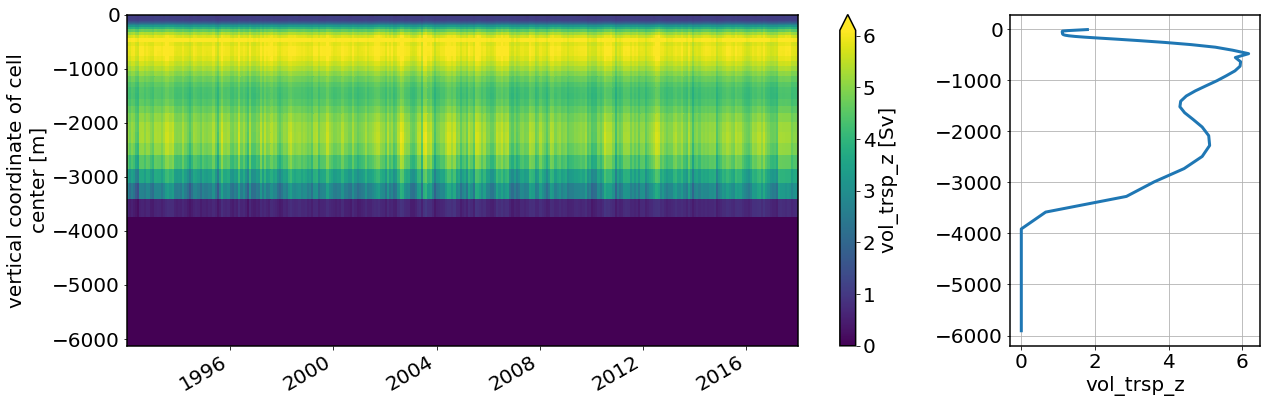

In [26]:
quick_depth_plot(dp.vol_trsp_z)

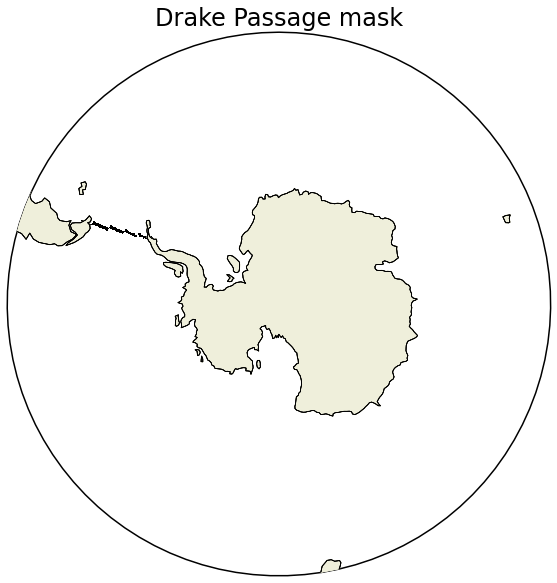

In [27]:
plt.rcParams.update({'figure.figsize':(10,10)})
ecco.plot_proj_to_latlon_grid(ds.XC,ds.YG,dp.maskS,projection_type='stereo',lat_lim=-45,show_grid_lines=False,cmap='gray_r');
plt.title('Drake Passage mask');

Content was borrowed from [this notebook](http://users.oden.utexas.edu/~tsmith/osm20_eccov4py_townhall_tsmith.html). This library package uses functions written in the `xgcm` and `xmitgcm` codes.

[Documentation](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_MHT.html#Grab-latitude-band:-26^\circN-array-as-an-example) for ECCOv4-py provides more info. 